In [1]:
import os
import os.path as path
import csv
import numpy as np

In [2]:
dataset_path = r"./dat/data-set-2016-TiO2/"

In [3]:
def check_periodics():
    count = 0

    # ripped and slightly modified from xsf_clean.py
    for s_no in range(1, 7816):
        file = path.join(
            dataset_path,
            f"structure{str(s_no).zfill(4)}.xsf"
        )
    
        with open(file, "r") as f:
            lines = f.readlines()
            if "PRIMVEC\n" in lines:
                count += 1

    print(f"non-periodic file count: {count}")

check_periodics()

non-periodic file count: 7815


In [4]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# suppress tensorflow warnings
import tensorflow as tf
import keras

from keras.models import Sequential 
from keras import Input
from keras.layers import Dense, \
                         Dropout

In [5]:
class BPNN(keras.Model):
    """
    The Model discussed in the 2007 paper by
    Behler and Parinello.

    This class contains an adaptive model which is
    the subnet for one atom.

    The subnet takes all the atom coordinates,
    and outputs the atomic contribution of energy
    """
    def __init__(self, layers: list, num_syms = 14):
        super().__init__()

        # properties of the subnet
        self.subnet   = Sequential([
            Input(shape = (num_syms,)),
            *layers
        ])
        self.ptl_out = Dense(1, activation = "linear")
        self.num_syms = num_syms

    def call(self, inputs, training = False):
        """
        Feed-forward algorithm for the model.
        split each row and feed to the subnet
        for each atom and applies to the same layers.
        """
        # splits the rows
        syms = tf.unstack(inputs, axis = 1)

        sym_e_contribution = []
        for sym in syms:
            # feed to subnet
            subnet_out = self.subnet(sym, training = training)
            ptl_out = self.ptl_out(subnet_out)
            sym_e_contribution.append(ptl_out)

        # turns the list into another tensor
        sym_preproc = tf.stack(sym_e_contribution, axis = 1)

        # add all the values in the tensor
        return tf.reshape(tf.reduce_sum(sym_preproc, axis = 1), [-1])

In [6]:
import pandas as pd
from sklearn.utils import shuffle

N_SYSTEMS = 116

# read all systems
X = np.array(
    [
        pd.read_csv(
            f"./dat/symmetries/sym{str(idx).zfill(4)}.csv"
        ).to_numpy()
        for idx in range(1, N_SYSTEMS + 1)
    ]
)

# read energy file
y = pd.read_csv(
    "./dat/energies.csv"
)[0:N_SYSTEMS]

In [7]:
print(np.shape(X))
X, y = shuffle(X, y)

lo = int(0.6 * N_SYSTEMS)
hi = int(0.8 * N_SYSTEMS)

X_train = X[:lo]
X_val   = X[lo:hi]
X_test  = X[hi:]

y_train = y[:lo]
y_val   = y[lo:hi]
y_test  = y[hi:]

(116, 95, 14)


In [8]:
model = BPNN([
        Dense(16, activation = "relu"),
        Dense(32, activation = "relu"),
        Dense(16, activation = "relu")
    ])

model.compile(
    optimizer = keras.optimizers.Adam(learning_rate=0.0001),
    loss = keras.losses.MeanAbsoluteError(),
    metrics = [keras.metrics.RootMeanSquaredError()]
)

In [9]:
n_epochs = 100
batch_sz = 10

bpnn = model.fit(
    X_train, y_train,
    batch_size = batch_sz,
    epochs = n_epochs,
    validation_data = (X_val, y_val),
    verbose = 0
)

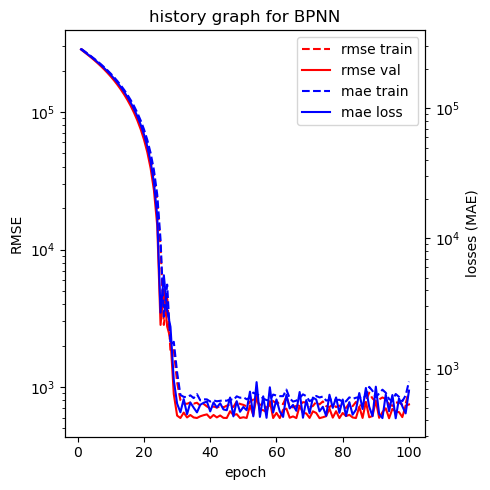

In [10]:
import matplotlib.pyplot as plt

xax = np.arange(1, n_epochs + 1)

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (5, 5))
ax.set_title("history graph for BPNN")
ax.set_xlabel("epoch")

tax = ax.twinx()

tax.set_ylabel("losses (MAE)")
ax.set_ylabel("RMSE")

ax.plot(
    xax, 
    bpnn.history["root_mean_squared_error"],
    "r--",
    label = "rmse train"
)

ax.plot(
    xax,
    bpnn.history["val_root_mean_squared_error"],
    "r-",
    label = "rmse val"
)

tax.plot(
    xax, 
    bpnn.history["loss"],
    "b--",
    label = "mae train"
)

tax.plot(
    xax, 
    bpnn.history["val_loss"],
    "b",
    label = "mae loss"
)


ax.set_yscale("log")
tax.set_yscale("log")

lns = [*ax.lines, *tax.lines]
labels = [ln.get_label() for ln in lns]

ax.legend(lns, labels)
plt.tight_layout()
plt.show()

In [11]:
preds = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


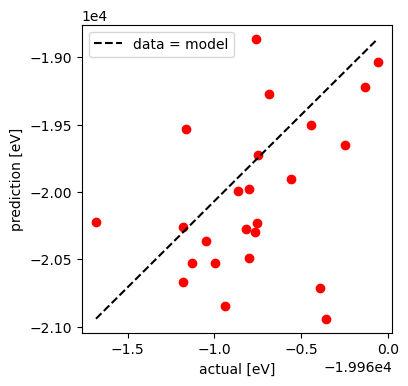

In [12]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (4,4))
ax.set_ylabel("prediction [eV]")
ax.set_xlabel("actual [eV]")
ax.ticklabel_format(axis = "both", style="sci", scilimits=(0,0))

y = y_test.to_numpy()
ax.scatter(y, preds, marker = "o", c="red")
ax.plot(
    [np.min(y), np.max(y)], 
    [np.min(preds), np.max(preds)],
    "k--",
    label = "data = model"
)

plt.legend()
plt.show()

# Tuned plots

In [13]:
import keras_tuner

def build_model(hp):
    tf.keras.backend.clear_session()
    n_layers = hp.Choice("layers", [2, 3, 4])
    units    = hp.Choice("units", [16, 32, 64])
    lrs      = hp.Choice("rates", [0.01, 0.001, 0.0001])
    model = BPNN([
        Dense(units, activation = "relu")
        for _ in range(n_layers)
    ])

    model.compile(
        optimizer = keras.optimizers.Adam(learning_rate = lrs),
        loss = keras.losses.MeanAbsoluteError(),
        metrics = [keras.metrics.RootMeanSquaredError()]
    )

    return model

In [14]:
tuner = keras_tuner.GridSearch(
    build_model,
    objective = "val_root_mean_squared_error",
    max_trials = 27
)

tuner.search(
    X_train, y_train,
    epochs = n_epochs,
    validation_data = (X_val, y_val),
    verbose = 0
)

Reloading Tuner from ./untitled_project/tuner0.json


In [15]:
tuned_hp = tuner.get_best_hyperparameters()[0]
tf.keras.backend.clear_session()
m_tuned = tuner.hypermodel.build(tuned_hp)
bpnn_tuned = m_tuned.fit(
    X_train, y_train,
    batch_size = batch_sz,
    epochs = n_epochs,
    validation_data = (X_val, y_val),
    verbose = 0
)

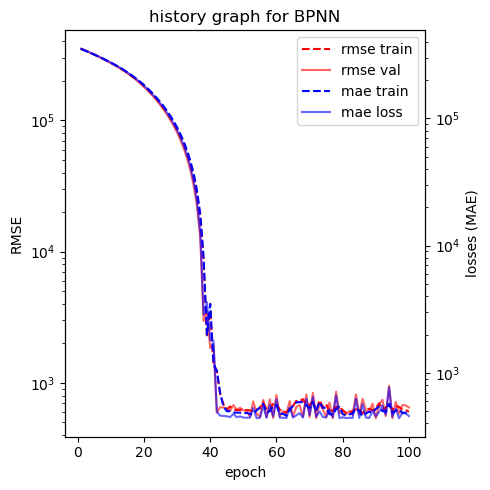

In [16]:
import matplotlib.pyplot as plt

xax = np.arange(1, n_epochs + 1)

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (5, 5))
ax.set_title("history graph for BPNN")
ax.set_xlabel("epoch")

tax = ax.twinx()

tax.set_ylabel("losses (MAE)")
ax.set_ylabel("RMSE")

ax.plot(
    xax, 
    bpnn_tuned.history["root_mean_squared_error"],
    "r--",
    label = "rmse train"
)

ax.plot(
    xax,
    bpnn_tuned.history["val_root_mean_squared_error"],
    "r-",
    alpha = 0.6,
    label = "rmse val"
)

tax.plot(
    xax, 
    bpnn_tuned.history["loss"],
    "b--",
    label = "mae train"
)

tax.plot(
    xax, 
    bpnn_tuned.history["val_loss"],
    "b",
    alpha = 0.6,
    label = "mae loss"
)


ax.set_yscale("log")
tax.set_yscale("log")

lns = [*ax.lines, *tax.lines]
labels = [ln.get_label() for ln in lns]

ax.legend(lns, labels)
plt.tight_layout()
plt.show()

In [18]:
preds = m_tuned.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


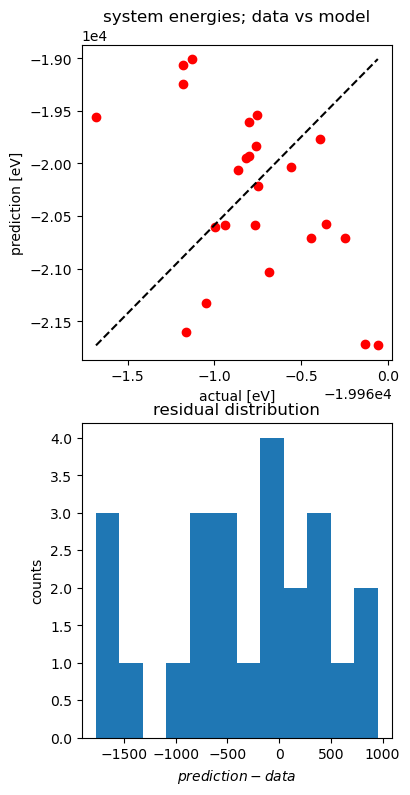

In [45]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (4,9))
ax[0].set_ylabel("prediction [eV]")
ax[0].set_xlabel("actual [eV]")
ax[0].ticklabel_format(axis = "both", style="sci", scilimits=(0,0))

y = y_test.to_numpy().reshape(-1)
ax[0].set_title("system energies; data vs model")
ax[0].scatter(y, preds, marker = "o", c="red")
ax[0].plot(
    [np.min(y), np.max(y)], 
    [np.min(preds), np.max(preds)],
    "k--"
)

diff = preds - y
ax[1].set_title("residual distribution")
ax[1].set_xlabel("prediction - data")
ax[1].set_ylabel("counts")
ax[1].hist(diff, bins = 12)

plt.show()